In [71]:
import matplotlib.pyplot as plt
#from matplotlib.animation import FuncAnimation
import seaborn as sns
import numpy as np
import math
from scipy.stats import norm, rayleigh,poisson,chi2
from scipy.optimize import minimize
from scipy.special import gamma,loggamma
from ipywidgets import interactive
import pandas as pd

Definitions:
H0 is Null Hyptohesis: Only background
H1 is Signal + Background
Notes:
1) When setting limits, H1/H0 swap roles!
2) Expected significance is median, not average


Let's define histogram bin borders

In [264]:
mass_min=0
mass_max=30
bins=120
histobins=np.linspace(mass_min,mass_max, bins+1)
print (histobins)

[ 0.    0.25  0.5   0.75  1.    1.25  1.5   1.75  2.    2.25  2.5   2.75
  3.    3.25  3.5   3.75  4.    4.25  4.5   4.75  5.    5.25  5.5   5.75
  6.    6.25  6.5   6.75  7.    7.25  7.5   7.75  8.    8.25  8.5   8.75
  9.    9.25  9.5   9.75 10.   10.25 10.5  10.75 11.   11.25 11.5  11.75
 12.   12.25 12.5  12.75 13.   13.25 13.5  13.75 14.   14.25 14.5  14.75
 15.   15.25 15.5  15.75 16.   16.25 16.5  16.75 17.   17.25 17.5  17.75
 18.   18.25 18.5  18.75 19.   19.25 19.5  19.75 20.   20.25 20.5  20.75
 21.   21.25 21.5  21.75 22.   22.25 22.5  22.75 23.   23.25 23.5  23.75
 24.   24.25 24.5  24.75 25.   25.25 25.5  25.75 26.   26.25 26.5  26.75
 27.   27.25 27.5  27.75 28.   28.25 28.5  28.75 29.   29.25 29.5  29.75
 30.  ]


Now, we define two functions, f_s_i and f_b_i, that will return the strength of signal and background in bin i (so that the integral over all bins would be 1). 
The signal is a norm and depends on a assumed signal position, pos, and width sigma
The back is a rayleigh and depnds on a assumed background pos, pos, and scale scale

In [234]:
def f_s_i(i,pos,sigma):
    assert i>=0, "i too small"
    assert i<=bins, "i too large"            
    return norm.cdf(histobins[i+1],pos,sigma)-norm.cdf(histobins[i],pos,sigma)

def f_b_i(i,pos,scale):
    assert i>=0, "i too small"
    assert i<=bins, "i too large"            
    return rayleigh.cdf(histobins[i+1],pos,scale)-rayleigh.cdf(histobins[i],pos,scale)

Let's plot them

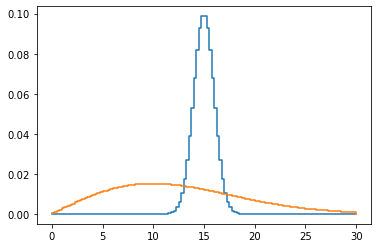

In [4]:
fig, ax = plt.subplots(1, 1)
ax.plot(histobins,[f_s_i(i,15,1) for i in range (bins)]+[0],ds="steps-post")
ax.plot(histobins,[f_b_i(i,0,10) for i in range (bins)]+[0],ds="steps-post")

Let's simulate one run of an experiment. We do this in two steps: First we'll build a histogram that provides the expected value for counts per bin, assuming expected total signal and total background events, mu, theta

In [5]:
def expected(mu,theta, spos,swidth,bpos,bwidth):
    return [theta*f_b_i(i,bpos,bwidth)+mu*f_s_i(i,spos,swidth) for i in range(bins)]

Then we draw from a poisson distribution, per bin, with the expected value set to the expected bin content. This simulates a real implementation of the experiment

In [6]:
def one_exp(bins):
    return [poisson.rvs(ev) for ev in bins]

Let's test this, and plot expected and three experiment runs

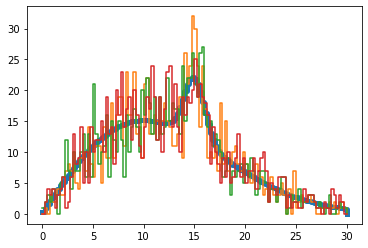

In [7]:
fig, ax = plt.subplots(1, 1)
exp=expected(100,1000,15,1,0,10)
ax.plot(histobins,exp+[0],ds="steps-post",lw=5)
ax.plot(histobins,one_exp(exp)+[0],ds="steps-post")
ax.plot(histobins,one_exp(exp)+[0],ds="steps-post")
ax.plot(histobins,one_exp(exp)+[0],ds="steps-post")

For now, we ignore the possibility of additional measurements that give info on theta. Then we can define the likelihood like this. We replace the factorial with the gamma function

In [8]:
def like(n,mu,theta, spos, swidth, bpos,bwidth):
        #we reuse expected to calcuale the expected number under the given assumptions:
        exp=expected(mu,theta,spos,swidth,bpos,bwidth)
        # Now we multiply up the likelihood parts:
        l=1
        for i in range(bins):
            l*=math.pow(exp[i],n[i])/gamma(n[i]+1)*math.exp(-exp[i])
        return l
    

This might be mathematically unstable. Let's calc the loglikelihood:

In [9]:
def loglike(n,mu,theta, spos, swidth, bpos,bwidth):
        #we reuse expected to calcuale the expected number under the given assumptions:
        exp=expected(mu,theta,spos,swidth,bpos,bwidth)
        # Now we multiply up the likelihood parts:
        l=0
        for i in range(bins):
            l+=math.log(exp[i])*n[i]-loggamma(n[i]+1)-exp[i]
        return l


Let's test this

In [10]:
n=expected(1,10,15,1,0,10)
#Perfect input should show large likelihood
print (like(n,1,10,15,1,0,10),math.exp(loglike(n,1,10,15,1,0,10)))

2.0461803265984995e-13 2.046180326598502e-13


This works, let's try larger numbers

In [11]:
n=expected(100,1000,15,1,0,10)
#Perfect input should show large likelihood
print (like(n,100,1000,15,1,0,10),math.exp(loglike(n,100,1000,15,1,0,10)))

1.393203883625507e-98 1.3932038836253948e-98


Ok, not quite the same, but close. Let's see the loglike curve as a function of the parameters (except the background shape parameters, we assume we know those)

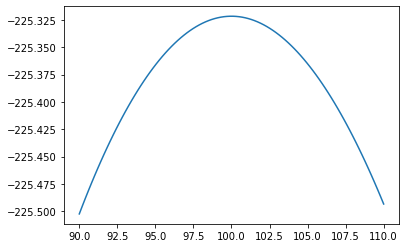

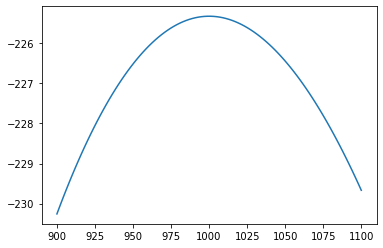

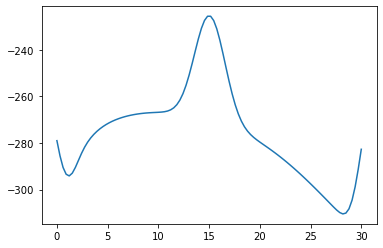

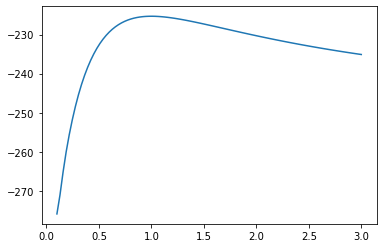

In [12]:
fig, ax = plt.subplots(1, 1)
xs=np.linspace(90,110,100)
ax.plot(xs,[loglike(n,x,1000,15,1,0,10) for x in xs])
fig, ax = plt.subplots(1, 1)
xs=np.linspace(900,1100,100)
ax.plot(xs,[loglike(n,100,x,15,1,0,10) for x in xs])
fig, ax = plt.subplots(1, 1)
xs=np.linspace(0,30,100)
ax.plot(xs,[loglike(n,100,1000,x,1,0,10) for x in xs])
fig, ax = plt.subplots(1, 1)
xs=np.linspace(0.1,3,100)
ax.plot(xs,[loglike(n,100,1000,15,x,0,10) for x in xs])



Next step is to write a function that optimizes both mu and theta, and one that optimzes theta for a given mu. 

In [13]:
def best_theta(n,mu, spos, swidth, bpos,bwidth):
    #we can estimate the best theta by the sum - mu
    xstart=[sum(n)-mu]
    re=minimize(lambda x: -loglike(n,mu,x[0],spos,swidth,bpos,bwidth),x0=xstart)
    return re.x[0]
def best_mu_theta(n,spos,swidth,bpos,bwidth):
    xstart=[sum(n)/1000,sum(n)]
    re=minimize(lambda x: -loglike(n,x[0],x[1],spos,swidth,bpos,bwidth),x0=xstart)
    return re.x[0],re.x[1]

In [14]:
exp=expected(100,1000,15,1,0,10) 
print (best_theta(exp,100,15,1,0,10))
n=one_exp(exp)
print (best_theta(n,100,15,1,0,10))
print (best_theta(n,101,15,1,0,10))
print (best_mu_theta(n,15,1,0,10))
print (best_mu_theta(exp,15,1,0,10))

1000.0053767523435
989.3330078125
988.565225327021
(134.36646246193698, 965.3539802725245)
(99.99920938749318, 1000.0066251870121)


Note that we could make this all a lot faster by optimizing loglike to not recalculate loggamma(n[i]) and exp[i] for every iteration. They are constant.

Next is the test statistics. We'll already use the one where we enforce that mu>=0

In [19]:
def lmbda(n,mu,spos,swidth,bpos,bwidth):   
    bmu,btheta=best_mu_theta(n,spos,swidth, bpos,bwidth)
    if bmu<0:
        bmu=0
        btheta=best_theta(n,0,spos,swidth, bpos,bwidth)
    btheta_fixed_mu=best_theta(n,mu,spos,swidth, bpos,bwidth)    
    return like(n,mu,btheta_fixed_mu,spos,swidth,bpos,bwidth)/like(n,bmu,btheta,spos,swidth,bpos,bwidth)

def t(n,mu,spos,swidth,bpos,bwidth):    
    bmu,btheta=best_mu_theta(n,spos,swidth, bpos,bwidth)
    if bmu<0:
        bmu=0
        btheta=best_theta(n,0,spos,swidth, bpos,bwidth)
    btheta_fixed_mu=best_theta(n,mu,spos,swidth, bpos,bwidth)
    return -2*(loglike(n,mu,btheta_fixed_mu,spos,swidth,bpos,bwidth)-loglike(n,bmu,btheta,spos,swidth,bpos,bwidth))

In [20]:
exp=expected(100,1000,15,1,0,10) 
n=one_exp(exp)
print (lmbda(n,100,15,1,0,10),t(n,100,15,1,0,10))

0.9294892400144543 0.14624009597673648


This works, but is slow, let's implement a faster fitter. Note that Nelder-mead gives better fits!

In [311]:

# This assumes that we have two hists fs,fb. loggamma can be ommitted, as it's a fixed value.
def semiloglikefast(n,mu,theta, fs,fb):    
        #print (mu,theta)
        l=np.log(mu*fs+theta*fb)*n-(mu*fs+theta*fb)
        #print ("SLF", mu,theta, np.sum(l), np.sum(np.log(mu*fs+theta*fb)*n),np.sum((mu*fs+theta*fb)))
        return np.sum(l)

def best_theta_fast(n,mu, spos, swidth, bpos,bwidth):
    #we can estimate the best theta by the sum - mu
    xstart=[sum(n)-mu]
    na=np.array(n)
    fs=np.array([f_s_i(i,spos,swidth) for i in range(bins)])
    fb=np.array([f_b_i(i,bpos,bwidth) for i in range(bins)])    
    re=minimize(lambda x: -semiloglikefast(na,mu,x[0],fs,fb),x0=xstart,method="Nelder-Mead")
    return re.x[0]
def best_mu_theta_fast(n,spos,swidth,bpos,bwidth):
    xstart=[0,sum(n)]    
    #print ("Xstart",xstart)
    na=np.array(n)
    fs=np.array([f_s_i(i,spos,swidth) for i in range(bins)])
    fb=np.array([f_b_i(i,bpos,bwidth) for i in range(bins)])
    re=minimize(lambda x: -semiloglikefast(na,x[0],x[1],fs,fb),x0=xstart,method="Nelder-Mead")
    return re.x[0],re.x[1]


In [42]:
import timeit
exp=expected(100,1000,15,1,0,10) 
print (timeit.timeit(lambda: best_mu_theta(exp,15,1,0,10),number=1))
print (timeit.timeit(lambda: best_mu_theta_fast(exp,15,1,0,10),number=1))


0.4926882260001548
0.016143733000262728


Let's define q0 and q_mu. We might want to also define qtildemu at some point.

In [140]:
def q0(n,mu,spos,swidth,bpos,bwidth):    
    bmu,btheta=best_mu_theta_fast(n,spos,swidth, bpos,bwidth)    
    if bmu<0:
        return 0
    btheta_fixed_mu=best_theta_fast(n,mu,spos,swidth, bpos,bwidth)
    
    return -2*(loglike(n,mu,btheta_fixed_mu,spos,swidth,bpos,bwidth)-loglike(n,bmu,btheta,spos,swidth,bpos,bwidth))

def qmu(n,mu,spos,swidth,bpos,bwidth):    
    bmu,btheta=best_mu_theta_fast(n,spos,swidth, bpos,bwidth)    
    if bmu>mu:
        return 0
    btheta_fixed_mu=best_theta_fast(n,mu,spos,swidth, bpos,bwidth)
    return -2*(loglike(n,mu,btheta_fixed_mu,spos,swidth,bpos,bwidth)-loglike(n,bmu,btheta,spos,swidth,bpos,bwidth))

Ok, good so far. Now we need the distributions to define p and the pdf and cdf of the test statistics. Let's do it experimentally first. We generate a ton of exp, and look at the distributions:

In [133]:
def nextQ0(thismany):
    # we generate one expected distribution:
    exp=expected(1000,100000,15,0.25,0,10)
    for i in range(thismany):
        n=one_exp(exp)        
        yield q0(n,0,15,0.25,0,10)
        
def nextQmu(mutest,thismany):
    exp=expected(1000,100000,15,0.25,0,10)
    for i in range (thismany):
        n=one_exp(exp)
        yield qmu(n,mutest,15,0.25,0,10)
        

In [25]:
import tqdm

1000it [02:13,  7.48it/s]


(array([  9.,  58.,  93., 178., 241., 200., 119.,  66.,  26.,  10.]),
 array([120.84180122, 137.15380782, 153.46581443, 169.77782103,
        186.08982763, 202.40183423, 218.71384083, 235.02584743,
        251.33785403, 267.64986064, 283.96186724]),
 <BarContainer object of 10 artists>)

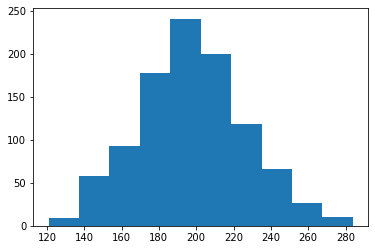

In [145]:
fig, ax = plt.subplots(1, 1)
ax.hist([i for i in tqdm.tqdm(nextQ0(1000))])

But to use Wald for the asymptotic limits, we need to get the mean mu and its standard dev. In the limit of a very large data set (i.e, the estimated best fit mu/theta are very close to the true value), the dataset is close to the asimov data set and we can get it using eq 30. We can cheat and get it from the expected dataset.

Discovery, however, doesn't need that. The pdf follows eq 51ff

In [80]:
def discoveryP(q0):
    return 1-norm.cdf(math.sqrt(q0))

In [144]:
#Example:
exp=expected(100,100000,15,0.5,0,10)

# We do this here for 
idealQ0=q0(exp,0,15,0.5,0,10)
print ("discovery P:", discoveryP(idealQ0))

exp0=expected(0,100000,15,0.5,0,10)
bad=0
for i in tqdm.tqdm(range (100)):    
    n=one_exp(exp0) # a random measurement with 0 signal
    expQ0=q0(n,0,15,0.25,0,10) # the q0 we get for that
    if expQ0>idealQ0:
        # a random measurement with 0 signal produced a larger q0 than our ideal one
        bad+=1
print ("Ratio:", bad/100)    
    
    



  3%|██▍                                                                              | 3/100 [00:00<00:05, 18.38it/s]

discovery P: 0.15366736293971917


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.88it/s]

Ratio: 0.15


Ok, let's look at experimental sensitivity for rejection. I.e. what is the expected rejection.
We want the median rejection Z_mu|0, which is given by sqrt(Q_mu)
lambda A mu is mu/muprime, muprime is mu in data

1.2814710107553544

In [318]:
# same as discoveryP
def rejectionP(qmu):
    if (qmu<0):
        return 1
    return 1-norm.cdf(math.sqrt(qmu))


def find_mu_for_median_p(n,p,spos, swidth,bpos,bwidth):
    a=0
    target_q=math.pow(norm.isf(p),2)    
    b=sum(n)/2 # signal not more than 1%?
    qa=qmu(n,a,spos,swidth,bpos,bwidth)-target_q
    qb=qmu(n,b,spos,swidth,bpos,bwidth)-target_q
    
    while b-a>0.1: # assuming mu to be signal counts. Otherwise smaller cutoff
        c=(a+b)/2
        qc=qmu(n,c,spos,swidth,bpos,bwidth)-target_q        
        if qc*qa>0:
            a=c
            qa=qc
        else:
            b=c
            qb=qc
        #print (qa,qb,a,b)
    return (b+a)/2,target_q
        

exp=expected(0,100000,15,0.5,0,10)
mmu,mq=find_mu_for_median_p(exp,0.15,15,0.5,0,10)
print (mmu,mq)

       



101.71117279372272 1.074194170857586


In [320]:
exp=expected(101.7,100000,15,0.5,0,10)

bad=0
for i in tqdm.tqdm(range (100)):
    n=one_exp(exp)    
    expQmu=qmu(n,101.7,15,0.5,0,10) # the q0 we get for that
    if expQmu>mq:
        # a random measurement with 0 signal produced a larger q0 than our ideal one
        bad+=1
print ("Ratio:", bad/100)    
    

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.82it/s]

Ratio: 0.14


In [325]:
exp=expected(0,100000,15,0.5,0,10)
n=one_exp(exp)
rejhist=[]
for i in tqdm.tqdm(range (bins)):
    bincenter=(histobins[i]+histobins[i+1])/2
    mmu,mq=find_mu_for_median_p(exp,0.15,bincenter,0.5,0,10)    
    rejhist.append(mmu)
    

100%|█████████████████████████████████████████████████████████████████████████████████| 120/120 [05:40<00:00,  2.84s/it]


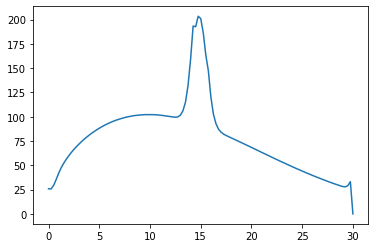

In [324]:
fig, ax = plt.subplots(1, 1)
ax.plot(histobins,rejhist+[0])